In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
import os
import pickle
import yfinance as yf
import pandas_datareader as pdr
import tensorflow as tf
from tensorflow.keras import layers
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [5]:
yf.pdr_override()
sp500 = yf.download('SPY', start='2016-01-04', end='2022-10-29')
sp500['return'] = np.log(sp500.Close/sp500.Close.shift(1))
sp500['cumreturn'] = sp500['return'].cumsum().apply(np.exp)
sp500.fillna(1, inplace=True)
sp500

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,return,cumreturn
Date,,,,,,,,
2016-01-04,200.490005,201.029999,198.589996,201.020004,177.237381,222353500,1.000000,1.000000
2016-01-05,201.399994,201.899994,200.050003,201.360001,177.537216,110845800,0.001690,1.001691
2016-01-06,198.339996,200.059998,197.600006,198.820007,175.297714,152112600,-0.012694,0.989056
2016-01-07,195.330002,197.440002,193.589996,194.050003,171.092026,213436100,-0.024284,0.965327
2016-01-08,195.190002,195.850006,191.580002,191.919998,169.214020,209817200,-0.011037,0.954731
...,...,...,...,...,...,...,...,...
2022-10-24,375.890015,380.059998,373.109985,378.869995,377.138184,85436900,0.012162,1.884738
2022-10-25,378.790009,385.250000,378.670013,384.920013,383.160522,78846300,0.015842,1.914834
2022-10-26,381.619995,387.579987,381.350006,382.019989,380.273773,104087300,-0.007563,1.900408


In [20]:
df = pd.read_csv(f"{os.path.dirname(os.getcwd())}\SP500 stock OHLC extended.csv", header=0, index_col=0, parse_dates=[0])
data = df.copy()
data = data.loc[data.index > '2004-08-11', :]
data

,Open,High,Low,Close,Adj Close,Volume,symbol,industry
Date,,,,,,,,
2004-08-12,15.579399,15.579399,13.955651,14.077253,12.044947,10592786.0,A,Health Care
2004-08-13,15.293276,15.464950,14.306152,14.678112,12.559063,11596550.0,A,Health Care
2004-08-16,14.556509,14.914163,14.549356,14.821173,12.681472,3200162.0,A,Health Care
2004-08-17,14.964235,15.228898,14.914163,15.157368,12.969130,4587677.0,A,Health Care
2004-08-18,15.193133,15.579399,15.135908,15.572246,13.324113,3756566.0,A,Health Care
...,...,...,...,...,...,...,...,...
2022-10-24,48.320000,50.049999,48.130001,49.779999,49.377518,2713000.0,ZION,Financials
2022-10-25,47.720001,51.869999,47.490002,51.509998,51.093529,3797100.0,ZION,Financials
2022-10-26,51.040001,51.939999,50.349998,50.400002,49.992508,1623000.0,ZION,Financials


In [6]:
top50 = pd.read_csv(f"{os.path.dirname(os.getcwd())}\SP500_Top50_MarketCap.csv", header=0, index_col=0)
top50

,symbol
0,AAPL
1,MSFT
2,AMZN
3,GOOGL
4,BRK.B
...,...
498,FOX
499,DVA
500,DISH
501,VNO


In [7]:
contains_top50 = []
counter = 0
index = 0
while counter < 50 and index < len(top50):
    ticker = top50.iloc[index].symbol
    if ticker in data.symbol.unique():
        contains_top50.append(ticker)
        counter += 1
    index += 1
len(contains_top50)

50

In [21]:
data_top50 = data.loc[data.symbol.isin(contains_top50), :]
data_top50.loc[:, 'log_close'] = np.log(data_top50.Close)
data_top50

C:\Users\kmlee\AppData\Local\Temp\ipykernel_27636\2154100266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_top50.loc[:, 'log_close'] = np.log(data_top50.Close)


,Open,High,Low,Close,Adj Close,Volume,symbol,industry,log_close
Date,,,,,,,,,
2004-08-12,0.543750,0.550893,0.540714,0.542321,0.462284,226200800.0,AAPL,Information Technology,-0.611897
2004-08-13,0.546429,0.558571,0.542857,0.550714,0.469438,328048000.0,AAPL,Information Technology,-0.596540
2004-08-16,0.553571,0.566429,0.547143,0.549643,0.468526,435674400.0,AAPL,Information Technology,-0.598486
2004-08-17,0.546071,0.555893,0.541964,0.551250,0.469895,323019200.0,AAPL,Information Technology,-0.595567
2004-08-18,0.544821,0.568750,0.544464,0.566786,0.483139,364655200.0,AAPL,Information Technology,-0.567773
...,...,...,...,...,...,...,...,...,...
2022-10-24,105.660004,107.680000,105.120003,106.599998,105.748695,17024200.0,XOM,Energy,4.669083
2022-10-25,106.410004,107.330002,105.070000,105.879997,105.034447,15719800.0,XOM,Energy,4.662306
2022-10-26,106.260002,107.830002,106.000000,107.139999,106.284386,17383800.0,XOM,Energy,4.674136


In [22]:
top50_df = pd.DataFrame()
for ticker in data_top50.symbol.unique():
    temp = data_top50.loc[data_top50.symbol==ticker, :]
    temp = temp.loc[(temp.index >= '2005-01-01') & (temp.index < '2015-01-01')]
    top50_df.loc[:, f'{ticker}'] = temp.loc[:, 'log_close']
top50_df

,AAPL,ABT,ACN,ADBE,AMGN,AMZN,BAC,BMY,CMCSA,COP,...,T,TMO,TXN,UNH,UNP,UPS,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,0.122376,3.108716,3.272227,3.428975,4.163249,0.800206,3.838592,3.235930,2.393948,3.467585,...,2.961544,3.390473,3.185526,3.768384,2.824944,4.442651,3.594942,3.432535,3.976874,3.913821
2005-01-04,0.132594,3.098594,3.248435,3.402197,4.147253,0.745265,3.824721,3.224858,2.368061,3.461024,...,2.950937,3.377929,3.161247,3.758056,2.800326,4.429864,3.584764,3.433342,3.974434,3.907010
2005-01-05,0.141314,3.087056,3.244544,3.396687,4.131319,0.736446,3.813086,3.210440,2.377383,3.468417,...,2.955665,3.375196,3.130700,3.761549,2.791165,4.427836,3.583266,3.434471,3.975749,3.901771
2005-01-06,0.142089,3.109358,3.235536,3.379974,4.140592,0.719059,3.811539,3.208825,2.375836,3.482806,...,2.944200,3.375880,3.126761,3.783394,2.797281,4.426761,3.571452,3.438011,3.989910,3.914420
2005-01-07,0.212371,3.126344,3.281287,3.380654,4.142658,0.749527,3.800644,3.208421,2.384779,3.476462,...,2.941413,3.361070,3.132010,3.775401,2.785011,4.424847,3.567906,3.436725,3.988799,3.907814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,3.332294,3.822098,4.514370,4.314015,5.079353,2.718100,2.889260,4.080077,3.368502,4.250351,...,3.244526,4.842532,4.004784,4.631617,4.789989,4.722153,3.864302,4.013496,4.459335,4.540952
2014-12-26,3.349816,3.825375,4.513713,4.313078,5.096568,2.737900,2.889260,4.087320,3.373997,4.246779,...,3.250691,4.849449,4.002777,4.630351,4.790736,4.717874,3.868280,4.012411,4.464873,4.534855
2014-12-29,3.349114,3.819908,4.505571,4.305820,5.092830,2.747399,2.896464,4.091173,3.382354,4.250065,...,3.248933,4.843084,3.997466,4.628203,4.793308,4.722509,3.861782,4.020160,4.461762,4.533352


In [10]:
def weakly_stationary(ts, cutoff=0.05):
    ts = np.ravel(ts)
    return adfuller(ts)[1] < cutoff

In [11]:
def cointegration(ts1, ts2):
    return coint(ts1, ts2)[1]

In [ ]:
# cutoff = 0.05
# coint_dic = {}
# for i in range(50):
#     arr1 = top50_df.iloc[:, i].to_numpy()
#     for j in range(i+1, 50):
#         arr2 = top50_df.iloc[:, j].to_numpy()
#         p_value = cointegration(arr1, arr2)
#         if p_value < cutoff:
#             coint_dic[p_value] = (top50_df.columns[i], top50_df.columns[j])

In [ ]:
# with open('coint_dic.pkl', 'wb') as f:
#     pickle.dump(coint_dic, f)

In [12]:
with open('coint_dic.pkl', 'rb') as f:
    coint_dic = pickle.load(f)

In [13]:
p_values = list(map(lambda x: x, coint_dic.keys()))
p_values.sort()
bot10_pvalues = p_values[:10]
bot10_pvalues

[9.379459083057298e-06,
 3.034808466958149e-05,
 0.0001221161476226386,
 0.00038432690429147465,
 0.00048539846351391643,
 0.0005479432216908223,
 0.0007776209555745435,
 0.001618693748037122,
 0.0017420139945032945,
 0.0018933286061999983]

In [35]:
def SMA_ratio(data, fast, slow):
    data['SMA_ratio'] = data.spread.transform(lambda x: x.rolling(window=fast).mean())/data.spread.transform(lambda x: x.rolling(window=slow).mean())

In [34]:
def RSI(data, fast, slow):
    data['Diff'] = data['spread'].transform(lambda x: x.diff())
    data['Up'] = data['Diff']
    data.loc[(data['Up']<0), 'Up'] = 0

    data['Down'] = data['Diff']
    data.loc[(data['Down']>0), 'Down'] = 0 
    data['Down'] = abs(data['Down'])

    data['avg_fast_up'] = data['Up'].transform(lambda x: x.rolling(window=fast).mean())
    data['avg_fast_down'] = data['Down'].transform(lambda x: x.rolling(window=fast).mean())

    data['avg_slow_up'] = data['Up'].transform(lambda x: x.rolling(window=slow).mean())
    data['avg_slow_down'] = data['Down'].transform(lambda x: x.rolling(window=slow).mean())

    data['RS_fast'] = data['avg_fast_up'] / data['avg_fast_down']
    data['RS_slow'] = data['avg_slow_up'] / data['avg_slow_down']

    data['RSI_fast'] = 100 - (100/(1+data['RS_fast']))
    data['RSI_slow'] = 100 - (100/(1+data['RS_slow']))

    data['RSI_ratio'] = data['RSI_fast']/data['RSI_slow']

In [39]:
def MACD(data, fast, slow):
    data['MACD'] = data['spread'].transform(lambda x: x.ewm(span=fast, adjust=False).mean()) - data['spread'].transform(lambda x: x.ewm(span=slow, adjust=False).mean())

In [51]:
def get_indicators(data, fast, slow):
    SMA_ratio(data, fast, slow)
    RSI(data, fast, slow)
    MACD(data, fast, slow)

In [127]:
indicators = ['SMA_ratio', 'RSI_ratio', 'spread', 'diff_spread', 'MACD']
lagged_indicators = []
lag = 30
for indicator in indicators:
    lagged_indicators.append(indicator)
    for i in range(1, lag):
        lagged_indicators.append(f'{indicator}_{i}')
lagged_indicators

['SMA_ratio',
 'SMA_ratio_1',
 'SMA_ratio_2',
 'SMA_ratio_3',
 'SMA_ratio_4',
 'SMA_ratio_5',
 'SMA_ratio_6',
 'SMA_ratio_7',
 'SMA_ratio_8',
 'SMA_ratio_9',
 'SMA_ratio_10',
 'SMA_ratio_11',
 'SMA_ratio_12',
 'SMA_ratio_13',
 'SMA_ratio_14',
 'SMA_ratio_15',
 'SMA_ratio_16',
 'SMA_ratio_17',
 'SMA_ratio_18',
 'SMA_ratio_19',
 'SMA_ratio_20',
 'SMA_ratio_21',
 'SMA_ratio_22',
 'SMA_ratio_23',
 'SMA_ratio_24',
 'SMA_ratio_25',
 'SMA_ratio_26',
 'SMA_ratio_27',
 'SMA_ratio_28',
 'SMA_ratio_29',
 'RSI_ratio',
 'RSI_ratio_1',
 'RSI_ratio_2',
 'RSI_ratio_3',
 'RSI_ratio_4',
 'RSI_ratio_5',
 'RSI_ratio_6',
 'RSI_ratio_7',
 'RSI_ratio_8',
 'RSI_ratio_9',
 'RSI_ratio_10',
 'RSI_ratio_11',
 'RSI_ratio_12',
 'RSI_ratio_13',
 'RSI_ratio_14',
 'RSI_ratio_15',
 'RSI_ratio_16',
 'RSI_ratio_17',
 'RSI_ratio_18',
 'RSI_ratio_19',
 'RSI_ratio_20',
 'RSI_ratio_21',
 'RSI_ratio_22',
 'RSI_ratio_23',
 'RSI_ratio_24',
 'RSI_ratio_25',
 'RSI_ratio_26',
 'RSI_ratio_27',
 'RSI_ratio_28',
 'RSI_ratio_29',
 'sp

In [133]:
def get_dataset(key, dic, train_val = True):
    temp = dic[key]
    temp = temp.iloc[:-lag, :] if train_val else temp
    x, y = temp.loc[:, lagged_indicators].to_numpy(), temp.loc[:, 'signal'].to_numpy()
    x_reshaped = np.array([np.transpose(row.reshape(5, 30)) for row in x])
    encoder = OneHotEncoder()
    y = encoder.fit_transform(y.reshape((-1, 1))).todense()
    return x_reshaped, y

In [134]:
x, y = get_dataset(('PEP', 'PG'), train_dic)
x.shape, y.shape

((2487, 30, 5), (2487, 3))

In [180]:
def plot_history(histories):
    fig, ax = plt.subplots(10, 2, figsize=(150,150))
    fig.tight_layout()
    metrics = ['accuracy', 'loss']
    for i in range(10):
        history = histories[i]
        for j in range(2):
            metric = metrics[j]
            ax[i,j].plot(history.history[f'{metric}'])
            ax[i,j].legend([f'train {metric}', f'{metric}'], loc='upper left')
            ax[i,j].set_title(f'cluster_{i}')
            ax[i,j].figure.set_size_inches(30,30)

In [177]:
train_dic = {}
test_dic = {}
volatility = 0.5
fast, slow = 5, 15

for ele in bot10_pvalues:
    ticker1, ticker2 = coint_dic[ele]
    req_cols = ['Open', 'Close', 'symbol', 'log_close']
    temp1= data_top50.loc[data_top50.symbol==ticker1, req_cols]
    temp1.rename(columns={'Open': 'Open1',
                         'Close': 'Close1',
                         'symbol': 'symbol1',
                         'log_close': 'log_close1'}, inplace=True)
    temp2= data_top50.loc[data_top50.symbol==ticker2, req_cols]
    temp2.rename(columns={'Open': 'Open2',
                         'Close': 'Close2',
                         'symbol': 'symbol2',
                         'log_close': 'log_close2'}, inplace=True)
    temp = temp1.merge(temp2, on='Date', how='left')
    temp.loc[:, 'spread'] = temp.log_close1 - temp.log_close2
    temp.loc[:, 'spread_shifted'] = temp.spread.shift(-7)
    temp.loc[:, 'diff_spread'] = temp.spread - temp.spread_shifted
    temp.loc[:, 'diff_spread_std_pos'] = temp.loc[temp.diff_spread > 0, 'diff_spread'].rolling(lag).std() * volatility
    temp.loc[:, 'diff_spread_std_neg'] = temp.loc[temp.diff_spread < 0, 'diff_spread'].rolling(lag).std() * volatility
    temp.loc[:, 'signal'] = np.where((temp.diff_spread > 0) & (temp.diff_spread > temp.diff_spread_std_pos), -1, 0)
    temp.loc[:, 'signal'] = np.where((temp.diff_spread < 0) & (temp.diff_spread < -temp.diff_spread_std_neg), 1, temp.signal)
    
    get_indicators(temp, fast, slow)
    
    for indicator in indicators[:2]:
        indicator_lst = [indicator]
        for i in range(1, lag):
            temp.loc[:, f'{indicator}_{i}'] = temp.loc[:, f'{indicator}'].shift(i)
            indicator_lst.append(f'{indicator}_{i}')
        tempT = temp.loc[temp.index >= '2005-01-01', indicator_lst].transpose()
        scaler = MinMaxScaler(feature_range=(0, 1))
        temp.loc[temp.index >= '2005-01-01', indicator_lst] = scaler.fit_transform(tempT).transpose()
        
    for indicator in indicators[2:]:
        indicator_lst = [indicator]
        for i in range(1, lag):
            temp.loc[:, f'{indicator}_{i}'] = temp.loc[:, f'{indicator}'].shift(i)
            indicator_lst.append(f'{indicator}_{i}')
        tempT = temp.loc[temp.index >= '2005-01-01', indicator_lst].transpose()
        scaler = MinMaxScaler(feature_range=(-1, 1))
        temp.loc[temp.index >= '2005-01-01', indicator_lst] = scaler.fit_transform(tempT).transpose()
    
    train = temp.loc[(temp.index >= '2005-01-01') & (temp.index < '2016-01-01'), :]
    test = temp.loc[temp.index >= '2016-01-01', :]
    
    for df in [train, test]: 
        df.loc[:, 'Close1_shifted'] = df.Close1.shift(-lag + 1)
        df.loc[:, 'Close2_shifted'] = df.Close2.shift(-lag + 1)
        df.loc[:, 'Target1'] = ((df.Close1_shifted-df.Open1)/df.Open1).shift(-1)
        df.loc[:, 'Target2'] = ((df.Close2_shifted-df.Open2)/df.Open2).shift(-1)

    train_dic[(ticker1, ticker2)] = train
    test_dic[(ticker1, ticker2)] = test

C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\sit

C:\Users\kmlee\AppData\Local\Temp\ipykernel_27636\1031414451.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Close1_shifted'] = df.Close1.shift(-lag + 1)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_27636\1031414451.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Close2_shifted'] = df.Close2.shift(-lag + 1)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_27636\1031414451.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\sit

C:\Users\kmlee\AppData\Local\Temp\ipykernel_27636\1031414451.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Close1_shifted'] = df.Close1.shift(-lag + 1)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_27636\1031414451.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Close2_shifted'] = df.Close2.shift(-lag + 1)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_27636\1031414451.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\sit

C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\sit

C:\Users\kmlee\AppData\Local\Temp\ipykernel_27636\1031414451.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Target2'] = ((df.Close2_shifted-df.Open2)/df.Open2).shift(-1)


In [184]:
with open('train_dic.pkl', 'wb') as f:
    pickle.dump(train_dic, f)
    
with open('test_dic.pkl', 'wb') as f:
    pickle.dump(test_dic, f)    

In [178]:
train_df = pd.concat(list(train_dic.values()))
train_df = train_df.loc[:, ['symbol1', 'symbol2'] + lagged_indicators + ['diff_spread_std_pos', 'diff_spread_std_neg', 'signal']]
train_df

,symbol1,symbol2,SMA_ratio,SMA_ratio_1,SMA_ratio_2,SMA_ratio_3,SMA_ratio_4,SMA_ratio_5,SMA_ratio_6,SMA_ratio_7,...,MACD_23,MACD_24,MACD_25,MACD_26,MACD_27,MACD_28,MACD_29,diff_spread_std_pos,diff_spread_std_neg,signal
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,PEP,PG,0.043187,0.000000,0.025226,0.057236,0.135032,0.209046,0.182287,0.170060,...,-0.222071,0.003341,0.440660,0.190288,0.007258,-0.283434,-0.335956,NaN,0.009494,0
2005-01-04,PEP,PG,0.105011,0.043187,0.000000,0.025226,0.057236,0.135032,0.209046,0.182287,...,-0.420239,-0.222071,0.003341,0.440660,0.190288,0.007258,-0.283434,NaN,0.009578,0
2005-01-05,PEP,PG,0.239890,0.123751,0.050894,0.000000,0.029728,0.067450,0.159129,0.246351,...,-0.709442,-0.420239,-0.222071,0.003341,0.440660,0.190288,0.007258,NaN,0.009519,0
2005-01-06,PEP,PG,0.290394,0.267339,0.137910,0.056718,0.000000,0.033129,0.075168,0.177337,...,-0.820007,-0.709442,-0.420239,-0.222071,0.003341,0.440660,0.190288,NaN,0.009469,1
2005-01-07,PEP,PG,0.392109,0.290394,0.267339,0.137910,0.056718,0.000000,0.033129,0.075168,...,-0.520442,-0.820007,-0.709442,-0.420239,-0.222071,0.003341,0.440660,NaN,0.009399,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,MSFT,WFC,0.990235,0.990111,0.989992,0.989847,0.990742,0.991778,0.994383,1.000000,...,-0.905908,-1.000000,-0.843512,-0.771861,-0.515100,-0.553691,-0.453046,NaN,0.008497,1
2015-12-28,MSFT,WFC,0.990414,0.990235,0.990111,0.989992,0.989847,0.990742,0.991778,0.994383,...,-0.759094,-0.905908,-1.000000,-0.843512,-0.771861,-0.515100,-0.553691,NaN,0.005693,1
2015-12-29,MSFT,WFC,0.990441,0.990414,0.990235,0.990111,0.989992,0.989847,0.990742,0.991778,...,-0.509550,-0.759094,-0.905908,-1.000000,-0.843512,-0.771861,-0.515100,NaN,0.005816,1


In [161]:
# Train LSTM models for each cluster

val_histories = []

for pair in train_dic.keys():
    ticker1, ticker2 = pair
    train_x, train_y = get_dataset(pair, train_dic)
    
    tf.random.set_seed(0)
    inputs = layers.Input(shape=(30, 5), dtype=tf.float32)
    x = layers.LSTM(128, activation='relu', input_shape=(1, 30, 5))(inputs)
    output = layers.Dense(3, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, output)
    model.compile(loss='categorical_crossentropy',
                 optimizer='Adam',
                 metrics=['accuracy'])
    
    history = model.fit(train_x,
                        train_y,
                        epochs=15)
    
    val_histories.append(history)
    file_loc = f'{os.getcwd()}\pair_{ticker1}_{ticker2}_model'
    tf.keras.models.save_model(model, file_loc)

Epoch 1/15
86/86 [==============================] - 8s 68ms/step - loss: 1.0719 - accuracy: 0.4173
Epoch 2/15
86/86 [==============================] - 6s 73ms/step - loss: 1.0438 - accuracy: 0.4684
Epoch 3/15
86/86 [==============================] - 6s 74ms/step - loss: 1.1430 - accuracy: 0.5115
Epoch 4/15
86/86 [==============================] - 6s 68ms/step - loss: 0.9944 - accuracy: 0.5473
Epoch 5/15
86/86 [==============================] - 6s 70ms/step - loss: 0.7808 - accuracy: 0.6517
Epoch 6/15
86/86 [==============================] - 6s 74ms/step - loss: 0.5423 - accuracy: 0.7561
Epoch 7/15
86/86 [==============================] - 7s 77ms/step - loss: 0.4183 - accuracy: 0.8189
Epoch 8/15
86/86 [==============================] - 6s 74ms/step - loss: 0.3716 - accuracy: 0.8437
Epoch 9/15
86/86 [==============================] - 7s 76ms/step - loss: 0.3273 - accuracy: 0.8598
Epoch 10/15
86/86 [==============================] - 6s 72ms/step - loss: 0.3324 - accuracy: 0.8587
Epoch 11/

86/86 [==============================] - 9s 75ms/step - loss: 1.0427 - accuracy: 0.4721
Epoch 2/15
86/86 [==============================] - 7s 82ms/step - loss: 1.0115 - accuracy: 0.5089
Epoch 3/15
86/86 [==============================] - 7s 80ms/step - loss: 0.9715 - accuracy: 0.5630
Epoch 4/15
86/86 [==============================] - 7s 77ms/step - loss: 0.6583 - accuracy: 0.7240
Epoch 5/15
86/86 [==============================] - 7s 76ms/step - loss: 0.4507 - accuracy: 0.7974
Epoch 6/15
86/86 [==============================] - 7s 78ms/step - loss: 0.3945 - accuracy: 0.8299
Epoch 7/15
86/86 [==============================] - 6s 75ms/step - loss: 0.3287 - accuracy: 0.8689
Epoch 8/15
86/86 [==============================] - 7s 76ms/step - loss: 0.3134 - accuracy: 0.8697
Epoch 9/15
86/86 [==============================] - 7s 82ms/step - loss: 0.3167 - accuracy: 0.8678
Epoch 10/15
86/86 [==============================] - 7s 87ms/step - loss: 0.2805 - accuracy: 0.8781
Epoch 11/15
86/86 [=

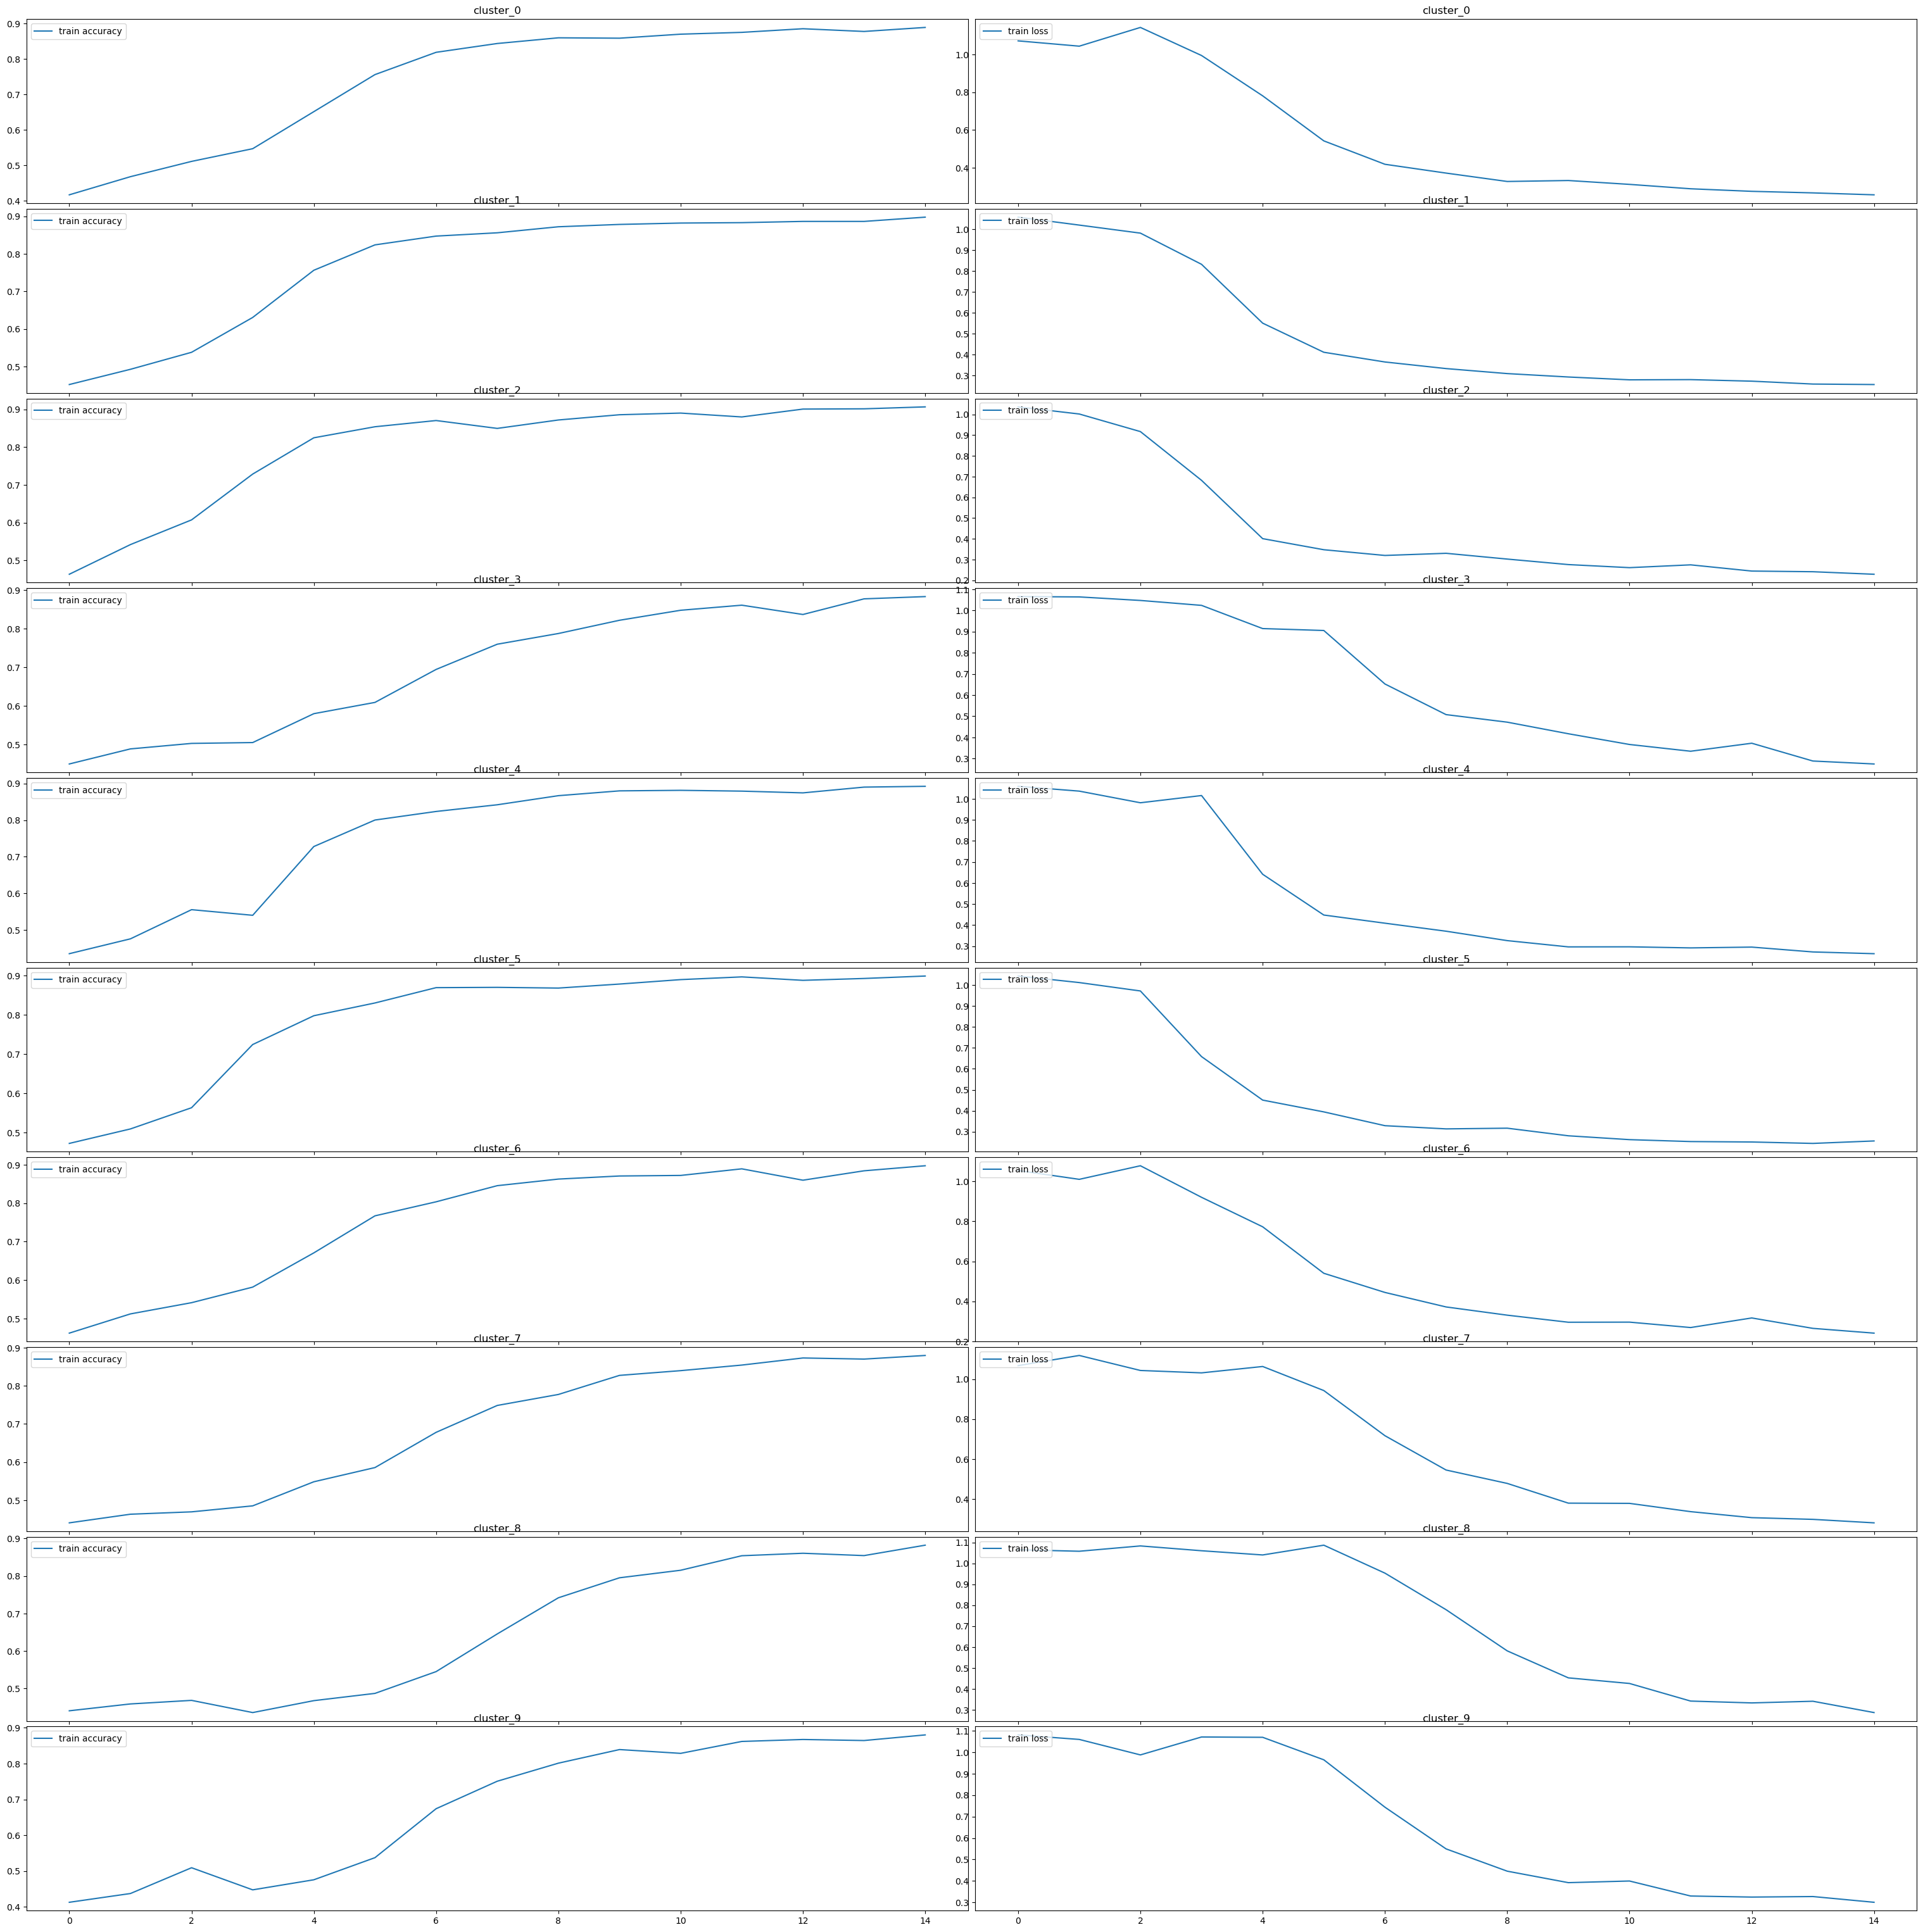

In [181]:
plot_history(val_histories)

In [162]:
x, y = get_dataset(('PEP', 'PG'), test_dic, False)
model = tf.keras.models.load_model(f'{os.getcwd()}\pair_PEP_PG_validated_model')
preds = model.predict(x)
preds

54/54 [==============================] - 2s 24ms/step


array([[2.0326204e-06, 2.3516205e-01, 7.6483595e-01],
       [7.6548807e-02, 9.0382874e-01, 1.9622510e-02],
       [9.9957985e-01, 4.2002124e-04, 6.2243167e-08],
       ...,
       [          nan,           nan,           nan],
       [          nan,           nan,           nan],
       [          nan,           nan,           nan]], dtype=float32)

In [163]:
# Make predictions on test data

preds = []
sample_df = test_dic[list(test_dic.keys())[0]]

for pair in test_dic.keys():
    ticker1, ticker2 = pair
    tf.keras.backend.clear_session()
    testx, _ = get_dataset(pair, test_dic, False)
    model = tf.keras.models.load_model(f'{os.getcwd()}\pair_{ticker1}_{ticker2}_model')
    df = pd.DataFrame({'ticker1': [ticker1]*len(sample_df),
                      'ticker2': [ticker2]*len(sample_df),
                      'position': np.argmax(model.predict(testx), axis=1)-1})
    df.set_index(sample_df.index, inplace=True)
    preds.append(df)
preds_df = pd.concat(preds)
preds_df

54/54 [==============================] - 2s 27ms/step


,ticker1,ticker2,position
Date,,,
2016-01-04,PEP,PG,1
2016-01-05,PEP,PG,0
2016-01-06,PEP,PG,-1
2016-01-07,PEP,PG,-1
2016-01-08,PEP,PG,-1
...,...,...,...
2022-10-24,MSFT,WFC,-1
2022-10-25,MSFT,WFC,-1
2022-10-26,MSFT,WFC,-1


In [164]:
for i in range(len(preds_df.index.unique())):
    date = list(preds_df.index.unique())[i]
    if i%lag != 0:
        preds_df.loc[preds_df.index == date, 'position'] = 0
preds_df

,ticker1,ticker2,position
Date,,,
2016-01-04,PEP,PG,1
2016-01-05,PEP,PG,0
2016-01-06,PEP,PG,0
2016-01-07,PEP,PG,0
2016-01-08,PEP,PG,0
...,...,...,...
2022-10-24,MSFT,WFC,0
2022-10-25,MSFT,WFC,0
2022-10-26,MSFT,WFC,0


In [165]:
preds_df.position.value_counts()

 0    16741
 1      226
-1      223
Name: position, dtype: int64

In [182]:
preds_df.to_csv('preds.csv')

In [183]:
preds_df = pd.read_csv('preds.csv', header=0, index_col=0, parse_dates=[0])
preds_df

,ticker1,ticker2,position
Date,,,
2016-01-04,PEP,PG,1
2016-01-05,PEP,PG,0
2016-01-06,PEP,PG,0
2016-01-07,PEP,PG,0
2016-01-08,PEP,PG,0
...,...,...,...
2022-10-24,MSFT,WFC,0
2022-10-25,MSFT,WFC,0
2022-10-26,MSFT,WFC,0


In [166]:
test_df = pd.concat(list(test_dic.values()))
test_df = test_df.loc[:, ['symbol1', 'symbol2', 'diff_spread_std_pos', 'diff_spread_std_neg', 'Target1', 'Target2', 'signal']]
test_df

,symbol1,symbol2,diff_spread_std_pos,diff_spread_std_neg,Target1,Target2,signal
Date,,,,,,,
2016-01-04,PEP,PG,NaN,0.003738,0.007489,0.051122,1
2016-01-05,PEP,PG,0.007284,NaN,0.012604,0.055491,0
2016-01-06,PEP,PG,0.007116,NaN,0.011375,0.064281,-1
2016-01-07,PEP,PG,0.006883,NaN,0.020853,0.061660,-1
2016-01-08,PEP,PG,0.006880,NaN,0.022601,0.074045,-1
...,...,...,...,...,...,...,...
2022-10-24,MSFT,WFC,NaN,NaN,NaN,NaN,0
2022-10-25,MSFT,WFC,NaN,NaN,NaN,NaN,0
2022-10-26,MSFT,WFC,NaN,NaN,NaN,NaN,0


In [148]:
def get_pnl(x):
    if list(preds_df.index).index(x.index[0])%lag == 0:
        return (x['position']*x['Target1']-x['position']*x['Target2']).sum()/x['position'].abs().sum() + 1
    return 1

In [109]:
def merge_preds(test_df, preds_df):
    temp = pd.concat([preds_df, test_df.loc[:, ['signal', 'Target1', 'Target2']]], axis=1)
    temp.set_index(test_df.index, inplace=True)
    return temp

In [110]:
def strategy_return(merged_preds_df):
    strategies = pd.DataFrame()
    strategies['avg return'] = merged_preds_df.groupby('Date').apply(get_pnl).shift(lag).fillna(1)
    strategies['strategy'] = np.log(strategies['avg return'])
    strategies['cumstrategy'] = strategies['strategy'].cumsum().apply(np.exp)
    return strategies

In [167]:
test_preds = merge_preds(test_df, preds_df)
test_preds

,ticker1,ticker2,position,signal,Target1,Target2
Date,,,,,,
2016-01-04,PEP,PG,1,1,0.007489,0.051122
2016-01-05,PEP,PG,0,0,0.012604,0.055491
2016-01-06,PEP,PG,0,-1,0.011375,0.064281
2016-01-07,PEP,PG,0,-1,0.020853,0.061660
2016-01-08,PEP,PG,0,-1,0.022601,0.074045
...,...,...,...,...,...,...
2022-10-24,MSFT,WFC,0,0,NaN,NaN
2022-10-25,MSFT,WFC,0,0,NaN,NaN
2022-10-26,MSFT,WFC,0,0,NaN,NaN


In [168]:
test_strategies = strategy_return(test_preds)
test_strategies

,avg return,strategy,cumstrategy
Date,,,
2016-01-04,1.0,0.0,1.000000
2016-01-05,1.0,0.0,1.000000
2016-01-06,1.0,0.0,1.000000
2016-01-07,1.0,0.0,1.000000
2016-01-08,1.0,0.0,1.000000
...,...,...,...
2022-10-24,1.0,0.0,8.491179
2022-10-25,1.0,0.0,8.491179
2022-10-26,1.0,0.0,8.491179


In [169]:
test_strategies.loc[test_strategies.index < '2021-01-01', :]

,avg return,strategy,cumstrategy
Date,,,
2016-01-04,1.0,0.0,1.000000
2016-01-05,1.0,0.0,1.000000
2016-01-06,1.0,0.0,1.000000
2016-01-07,1.0,0.0,1.000000
2016-01-08,1.0,0.0,1.000000
...,...,...,...
2020-12-24,1.0,0.0,4.229604
2020-12-28,1.0,0.0,4.229604
2020-12-29,1.0,0.0,4.229604


In [170]:
num_reset_days = 0
corr_preds = []

for i in range(len(list(test_strategies.index)[:-lag])):
    if i%lag == 0:
        date = list(test_strategies.index)[i]
        temp = test_preds.loc[test_preds.index == date, ['position', 'signal']]
        corr_preds.append(np.sum(np.where(temp.position == temp.signal, 1, 0)))
        num_reset_days += 1
        
hit_rate = np.sum(np.asarray(corr_preds))/(num_reset_days*10)
hit_rate

0.8771929824561403

In [171]:
for i in range(len(list(test_strategies.loc[test_strategies.index < '2021-01-01', :].index)[:-lag])):
    if i%lag == 0:
        date = list(test_strategies.index)[i]
        temp = test_preds.loc[test_preds.index == date, ['position', 'signal']]
        corr_preds.append(np.sum(np.where(temp.position == temp.signal, 1, 0)))
        num_reset_days += 1
        
hit_rate = np.sum(np.asarray(corr_preds))/(num_reset_days*10)
hit_rate

0.8785714285714286

In [119]:
def plot_returns(benchmark, strategy, title):
    plt.figure(figsize=(20, 12))
    plt.plot(pd.to_datetime(strategy.index).date, strategy.cumstrategy, label='Model')
    plt.plot(benchmark.index, benchmark['cumreturn'], color='red', label='SP500 Buy & Hold')
    plt.title(title)
    plt.gca().grid(True)
    plt.legend()

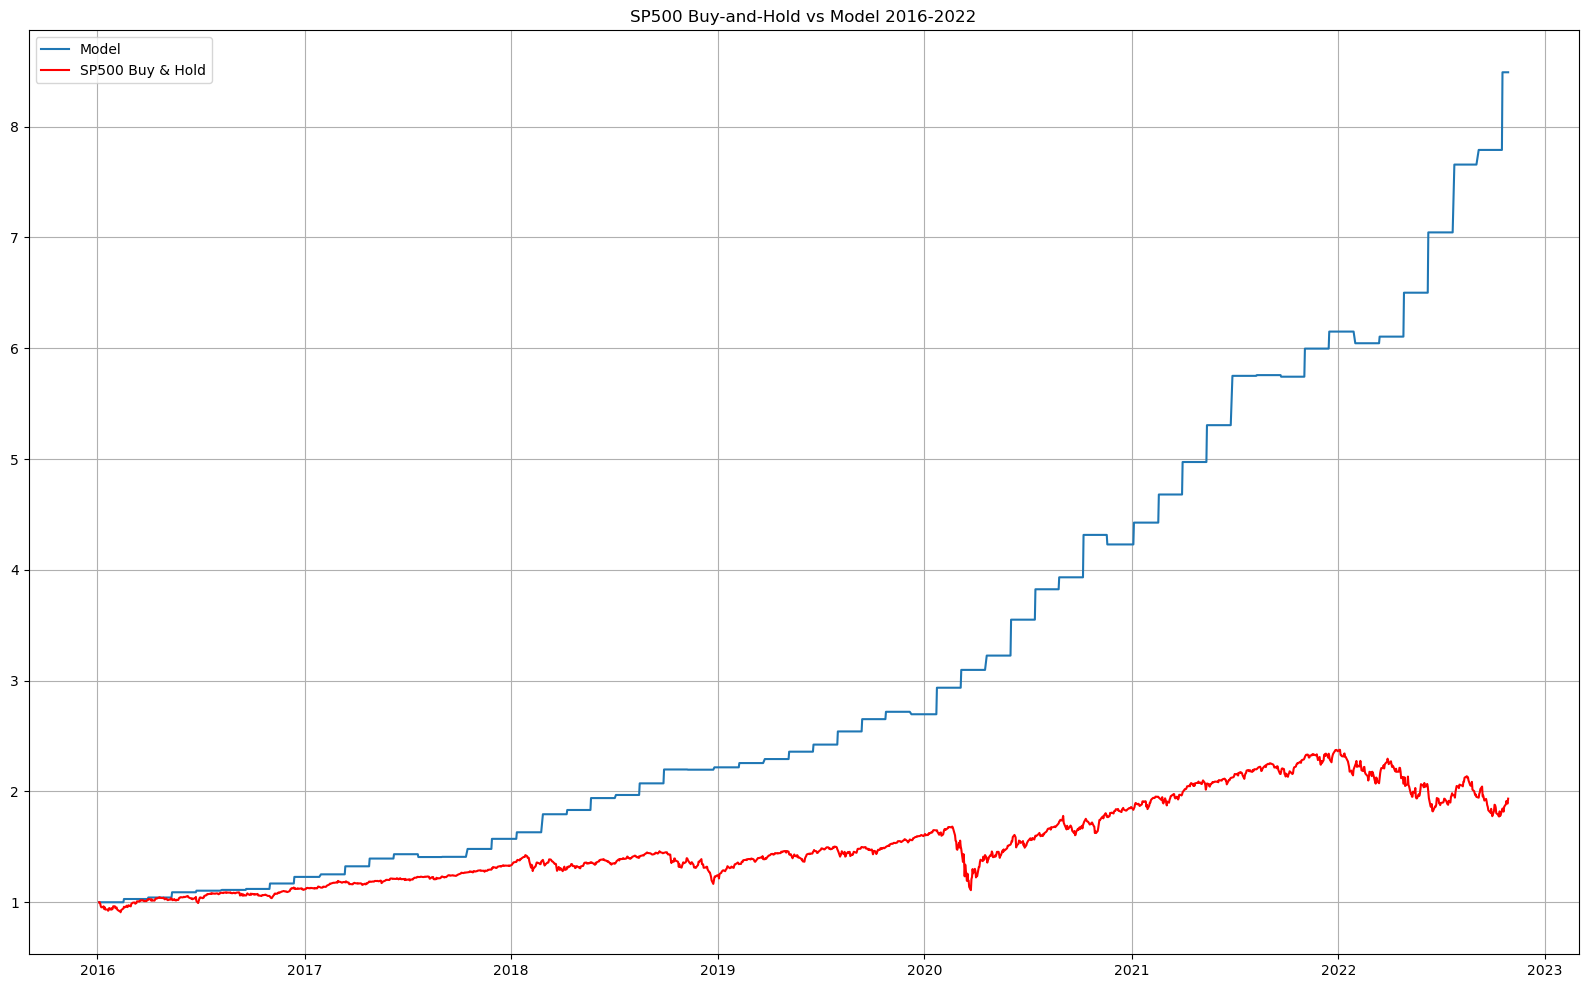

In [172]:
plot_returns(sp500, test_strategies, 'SP500 Buy-and-Hold vs Model 2016-2022')

In [173]:
sp500_weekly = sp500.copy()
sp500_weekly['Close shifted'] = sp500_weekly.Close.shift(-lag+1)
sp500_weekly['Target'] = ((sp500_weekly['Close shifted']-sp500_weekly.Open)/sp500_weekly.Open).shift(-1)
sp500_weekly_return = []
for i in range(len(sp500_weekly)):
    if i%lag == 0:
        sp500_weekly_return.append(sp500_weekly.iloc[i]['Target'])
    else:
        sp500_weekly_return.append(0)
temp_df = pd.DataFrame({'return': sp500_weekly_return}).shift(lag)
temp_df =  temp_df.loc[temp_df['return'] != 0, 'return'].dropna()
sp500_sharpe = temp_df.mean()/temp_df.std()
sp500_sharpe

0.3023300574480291

In [174]:
strategy_weekly_return = test_strategies.loc[test_strategies['avg return'] != 1, 'avg return'] - 1
strategy_sharpe = strategy_weekly_return.mean()/strategy_weekly_return.std()
strategy_sharpe

1.2240105233631913

In [175]:
sp500_weekly = sp500.loc[sp500.index < '2021-01-01', :]
sp500_weekly['Close shifted'] = sp500_weekly.Close.shift(-lag+1)
sp500_weekly['Target'] = ((sp500_weekly['Close shifted']-sp500_weekly.Open)/sp500_weekly.Open).shift(-1)
sp500_weekly_return = []
for i in range(len(sp500_weekly)):
    if i%lag == 0:
        sp500_weekly_return.append(sp500_weekly.iloc[i]['Target'])
    else:
        sp500_weekly_return.append(0)
temp_df = pd.DataFrame({'return': sp500_weekly_return}).shift(lag)
temp_df =  temp_df.loc[temp_df['return'] != 0, 'return'].dropna()
sp500_sharpe = temp_df.mean()/temp_df.std()
sp500_sharpe

C:\Users\kmlee\AppData\Local\Temp\ipykernel_27636\2560027239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_weekly['Close shifted'] = sp500_weekly.Close.shift(-lag+1)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_27636\2560027239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_weekly['Target'] = ((sp500_weekly['Close shifted']-sp500_weekly.Open)/sp500_weekly.Open).shift(-1)


0.37622827412190246

In [176]:
strategy_weekly_return = test_strategies.loc[(test_strategies['avg return'] != 1) & (test_strategies.index < '2021-01-01'), 'avg return'] - 1
strategy_sharpe = strategy_weekly_return.mean()/strategy_weekly_return.std()
strategy_sharpe

1.1980970535245008